In [14]:
import pandas as pd
import numpy as np
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (7.0, 10.0)

In [16]:
def parse_time(raw_time):
    '''Parse the raw time strings into timedeltas for doing arithmetic on the times'''
    if raw_time == '' or None:
        return None
    else:
        try:
            dt = datetime.datetime.strptime(str(raw_time), '%M:%S.%f')
            timedelta = datetime.timedelta(minutes=dt.minute, seconds=dt.second, microseconds=dt.microsecond)
            return timedelta
        except:
            dt = datetime.datetime.strptime(str(raw_time), '%S.%f')
            timedelta = datetime.timedelta(seconds=dt.second, microseconds=dt.microsecond)
            return timedelta


def timedeltaToString(rawTd):
    '''Convert timedelta to a MM:SS.000 formatted string'''
    try:
        dt = str(rawTd)[-12:-3]
        return dt
    except:
        return None

In [17]:
def processResults(df):
    '''Calculate split times, time gaps and rankings for each rider'''
    #Apply the time parser to the raw times
    for i in range(1,6):
        df['split' + str(i)] = df['split' + str(i)].apply(parse_time)

    #Calculate the total sector times for each split
    df['sector1'] = df['split1']
    df['sector2'] = df['split2'] - df['split1']
    df['sector3'] = df['split3'] - df['split2']
    df['sector4'] = df['split4'] - df['split3']
    df['sector5'] = df['split5'] - df['split4']

    #Calculate the time gaps and rankings for everything
    cols = ['sector1', 'sector2', 'sector3','sector4', 'sector5', 'split1', 'split2', 'split3','split4', 'split5']

    for col in cols:
        df[col + 'Gap'] = df[col].apply(lambda x: (x - df[col].min())/np.timedelta64(1,'s'))
        df[col + 'Rank'] = df[col].rank().astype(int)
        df[col] = df[col].apply(timedeltaToString)
        df[col + 'Rank']

    return df

In [25]:
df_raw = pd.read_excel('2016_04_LeogangMen_munged.xlsx')

def splitimes(df):
    df['Name'] = df['Name / UCI MTB Team'].apply(lambda x: x.split('\n')[0])
    df['split1'] = df['Split 1 & 2'].apply(lambda x: x.split('\n')[0])
    df['split2'] = df['Split 1 & 2'].apply(lambda x: x.split('\n')[1])
    df['split3'] = df['Split 3 & 4'].apply(lambda x: x.split('\n')[0])
    df['split4'] = df['Split 3 & 4'].apply(lambda x: x.split('\n')[1])
    df['split5'] = df['Time']

    df = df[['Name', 'split1', 'split2','split3','split4','split5']]
    
    return df

df_raw = splitimes(df_raw)
df_raw.head()

,Name,split1,split2,split3,split4,split5
0,GWIN Aaron,52.433,1:32.212,2:10.970,2:57.720,3:28.686
1,VERGIER Loris,52.089,1:30.957,2:11.501,3:00.175,3:31.817
2,BROSNAN Troy,52.502,1:32.689,2:13.303,3:01.879,3:32.804
3,HART Danny,53.070,1:33.014,2:13.614,3:01.691,3:34.055
4,MINNAAR Greg,52.855,1:33.467,2:13.459,3:03.101,3:35.165


In [26]:
df = processResults(df_raw)
df.head()

,Name,split1,split2,split3,split4,split5,sector1,sector2,sector3,sector4,...,split1Gap,split1Rank,split2Gap,split2Rank,split3Gap,split3Rank,split4Gap,split4Rank,split5Gap,split5Rank
0,GWIN Aaron,00:52.433,01:32.212,02:10.970,02:57.720,03:28.686,00:52.433,00:39.779,00:38.758,00:46.750,...,0.344,2,1.255,2,0.000,1,0.000,1,0.000,1
1,VERGIER Loris,00:52.089,01:30.957,02:11.501,03:00.175,03:31.817,00:52.089,00:38.868,00:40.544,00:48.674,...,0.000,1,0.000,1,0.531,2,2.455,2,3.131,2
2,BROSNAN Troy,00:52.502,01:32.689,02:13.303,03:01.879,03:32.804,00:52.502,00:40.187,00:40.614,00:48.576,...,0.413,3,1.732,3,2.333,3,4.159,4,4.118,3
3,HART Danny,00:53.070,01:33.014,02:13.614,03:01.691,03:34.055,00:53.070,00:39.944,00:40.600,00:48.077,...,0.981,7,2.057,4,2.644,5,3.971,3,5.369,4
4,MINNAAR Greg,00:52.855,01:33.467,02:13.459,03:03.101,03:35.165,00:52.855,00:40.612,00:39.992,00:49.642,...,0.766,4,2.510,5,2.489,4,5.381,5,6.479,5


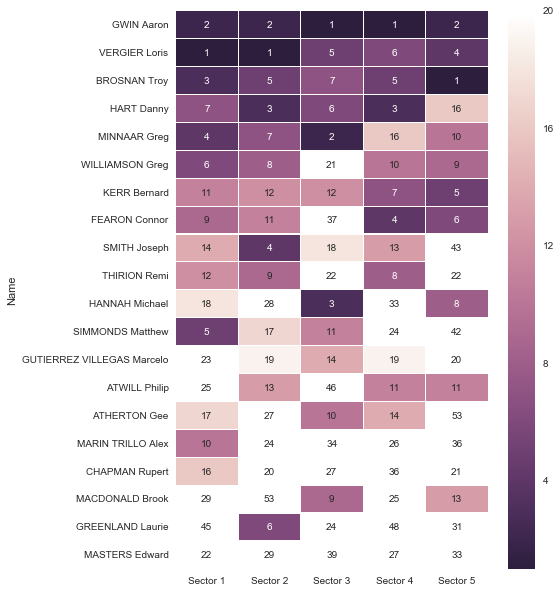

In [53]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", linewidths=.1, vmin=1, vmax=20, cmap=cmap)
heatmap.figure.savefig('leogang_heatmap.png', bbox_inches='tight')

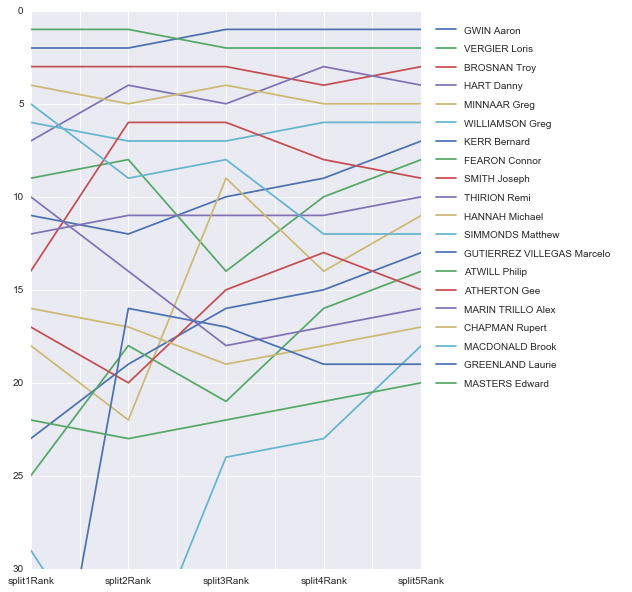

In [35]:
df_splittimes = df[df['split5Rank'] <= 20][['Name', 'split1Rank','split2Rank', 'split3Rank', 'split4Rank', 'split5Rank']]
df_splittimes = df_splittimes.set_index('Name')
df_splittimes = df_splittimes.T

sns.set_style("darkgrid")
df_splittimes.plot()
axes = plt.gca()
axes.set_ylim([0,30])
axes.invert_yaxis()
plt.legend(bbox_to_anchor=(1, 1), labelspacing=0.96, borderpad=1.5, loc=2, borderaxespad=0.)
plt.savefig('leogang_positiontracker.png', bbox_inches='tight')

In [37]:
groups = ['split1', 'split2', 'split3','split4','split5','sector1', 'sector2', 'sector3','sector4','sector5']

for group in groups:
    segment = df[['Name', group + 'Rank', group, group + 'Gap']].sort_values(group + 'Rank', ascending=True)[:20]
    cols = ['Name', 'Position', 'Time', 'Gap']
    segment.columns = cols
    segment.to_json(group + '.json', orient='records')

In [49]:
df[df['Name'] == "SHAW Luca"].iloc[0]

Name           SHAW Luca
split1         00:54.210
split2         01:37.127
split3         02:17.385
split4         03:05.201
split5         03:45.724
sector1        00:54.210
sector2        00:42.917
sector3        00:40.258
sector4        00:47.816
sector5        00:40.523
sector1Gap         2.121
sector1Rank           20
sector2Gap         4.049
sector2Rank           33
sector3Gap           1.5
sector3Rank            4
sector4Gap         1.066
sector4Rank            2
sector5Gap         9.598
sector5Rank           81
split1Gap          2.121
split1Rank            20
split2Gap           6.17
split2Rank            25
split3Gap          6.415
split3Rank            13
split4Gap          7.481
split4Rank             7
split5Gap         17.038
split5Rank            36
Name: 35, dtype: object